# Solution of the truss problem

First of all the data needs to be declared. These include

- the number of nodes
- the number of elements
- the coordinates of the nodes
- the connectivity of the members
- the element stiffness
- the nodal forces vector
- the boundary conditions

To have consistent units the Young modulus is expressed in [kN/m^2], the area in [m^2] and the length in [m]. This means that the external forces need to be expressed in [kN]. 

The obtained displacement will be expressed in [m] and the reaction forces are also expressed in [kN].

The following code declares the data for the problem



In [11]:
import numpy as np

A = 4000 * 1e-6 # m^2
E = 70 * 1e6 # kPa

EA = A * E

L_1 = 6 # m
L_2 = 4 # m
H = 8   # m

# The nodes are numbered from the bottom to the top, from the left to the right

node_1 = np.array([0, 0])
node_2 = np.array([L_1 + L_2, 0])
node_3 = np.array([0, H])
node_4 = np.array([L_1, H])

coordinates = np.vstack((node_1, node_2, node_3, node_4))

connectivity_table = np.array([[1, 3],
                                [3, 4],
                                [1, 4],
                                [2, 3],
                                [2, 4]]) - 1 # -1 because of python convention

n_nodes = coordinates.shape[0]
n_elements = connectivity_table.shape[0]

n_dofs = n_nodes * 2

# Dictionary containing information on the force value at solicitated nodes
dict_forces_1 = {3: np.array([0, - 400]),
               4: np.array([800, - 400])}

f = np.zeros(n_dofs)

for node, force_node in dict_forces_1.items():
    node_id = node - 1
    f[2*node_id:2*node_id+2] = force_node


# Node 1, 2 fixes the x, y displacement. Node 3 fixes the x displacement
dofs_bcs = [0, 1, 2, 3, 4]

Then the second part consists in assembling the stiffness matrix. First of all we verify that the mesh is correct by plotting the different elements    

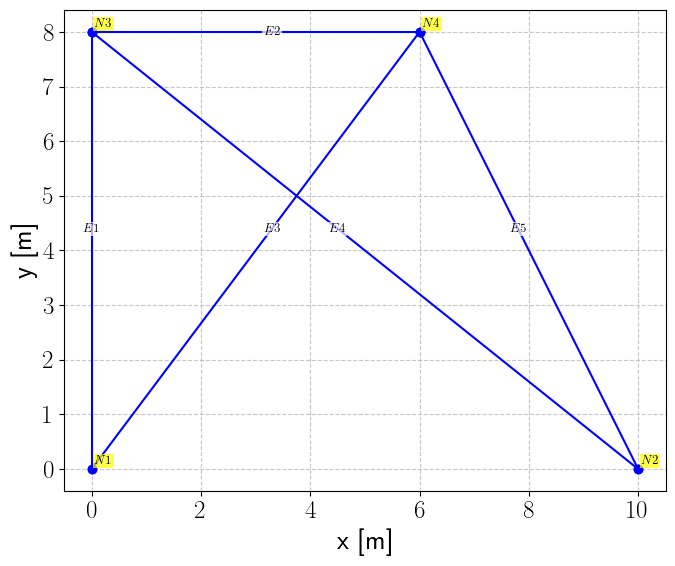

In [12]:
from src.postprocessing.plot_mesh import plot_truss_structure
from matplotlib import pyplot as plt

ax = plot_truss_structure(coordinates, connectivity_table,
        show_element_labels=True,
        show_node_labels=True,
        color='blue',
        linestyle='o-',
        xlabel='x [m]',
        ylabel='y [m]',)

Once the mesh has been verified, we can proceed to the construction of the stiffness matrix

In [39]:
from src.fem.assemble_stiffness import assemble_stiffness_truss_2d
from src.fem.solve_system import solve_system_homogeneous_bcs

K, _, _ = assemble_stiffness_truss_2d(coordinates, connectivity_table, EA)
q_all, reactions = solve_system_homogeneous_bcs(K, f, dofs_bcs)

q_all_mm = [round(v, 4) for v in 1e3*q_all]
print(f"Displacement at these nodes [mm]:\n {q_all_mm}\n")
print(f"Reactions at bcs in [kN]:\n {reactions}\n")

Displacement at these nodes [mm]:
 [0.0, 0.0, 0.0, 0.0, 0.0, -9.1886, 12.8365, -9.5844]

Reactions at bcs in [kN]:
 [  -0.57760745  320.82925204 -298.3858275   479.17074796 -501.03656505]



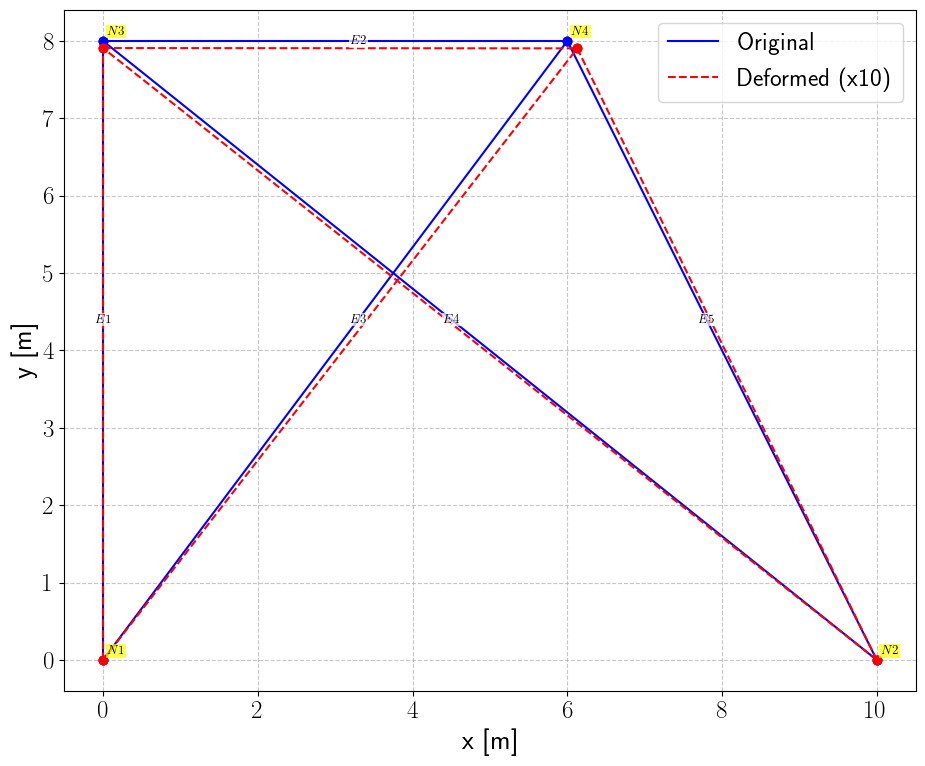

In [14]:
# Plot the obtained solution by amplifying the displacements
from src.postprocessing.plot_mesh import plot_truss_structure

fig, ax = plt.subplots(figsize=(10, 8))
ax = plot_truss_structure(coordinates, connectivity_table, ax=ax, 
        show_element_labels=True,
        show_node_labels=True,
        color='blue',
        linestyle='o-',
        label='Original',
        xlabel='x [m]',
        ylabel='y [m]',)

scale = 10
deformed_coordinates = coordinates + scale * q_all.reshape(-1, 2)
ax = plot_truss_structure(deformed_coordinates, connectivity_table, ax=ax, color='red',
        linestyle='o--',
        show_element_labels=False,
        show_node_labels=False,
        label=f'Deformed (x{scale})')
plt.tight_layout()
plt.show()

Then we can reconstruct the displacements and reaction forces at each node and find the axial force in each element

In [30]:
from src.fem.compute_strains_forces import compute_strains_forces_truss_2d

f_all = K @ q_all

axial_strains, axial_forces = compute_strains_forces_truss_2d(coordinates, \
                                                    connectivity_table, q_all, EA)

for ii in range(n_elements):
    print(f"Axial force in element {ii+1} [MPa]: \n {axial_forces[ii]:.3f}")

Axial force in element 1 [MPa]: 
 -321.599
Axial force in element 2 [MPa]: 
 599.037
Axial force in element 3 [MPa]: 
 0.963
Axial force in element 4 [MPa]: 
 -125.502
Axial force in element 5 [MPa]: 
 -448.075


Since the structure is isostatic the axial forces do not depend on the physical parameters of each truss.
We can verify it by changing the parameters and compute the forces again

In [ ]:
from scipy.sparse.linalg import norm

E_2 = 80 * 1e6 # kPa
A_2 = 3000 * 1e-6 # m^2
EA_2 = A_2 * E_2

K_2, _, _ = assemble_stiffness_truss_2d(coordinates, connectivity_table, EA_2)
print(f"Norm Diff stiffness matrix: \n {norm(K - K_2, ord='fro')}")

q_all_K2, reactions_K2 = solve_system_homogeneous_bcs(K_2, f, dofs_bcs)

print(f'Reactions for K2: \n {reactions_K2}')
axial_strains_K2, axial_forces_K2 = compute_strains_forces_truss_2d(coordinates, \
                                                    connectivity_table, q_all_K2, EA_2)

for ii in range(n_elements):
    print(f"Difference local force in element {ii+1}: \n {axial_forces[ii] - axial_forces_K2[ii]:.1f} [kN]")


Norm Diff stiffness matrix: 
 24192.927181070372
reactions for K2: 
 [  -0.57760745  320.82925204 -298.3858275   479.17074796 -501.03656505]
Difference local force in element 1: 
 0.0 [kN]
Difference local force in element 2: 
 0.0 [kN]
Difference local force in element 3: 
 -0.0 [kN]
Difference local force in element 4: 
 0.0 [kN]
Difference local force in element 5: 
 -0.0 [kN]


In [ ]:
# Second load case 
dict_forces_2 = {4: np.array([1500, 0])}
f_2 = np.zeros(n_dofs)

for node, force_node in dict_forces_2.items():
    node_id = node - 1
    f_2[2*node_id:2*node_id+2] = force_node

q_all_f2, reactions_f2 = solve_system_homogeneous_bcs(K, f_2, dofs_bcs)

print(f"Displacement [mm]:\n {q_all_f2*1e3}\n")
print(f"Reactions at bcs in [kN]:\n {reactions_f2}\n")

f_all_f2 = K @ q_all_f2

axial_strains_f2, axial_forces_f2 = compute_strains_forces_truss_2d(coordinates, \
                                                connectivity_table, q_all_f2, EA)

for ii in range(n_elements):
    print(f"Local axial force element {ii+1} in [kN]: \n {axial_forces_f2[ii]:.1f}")

In order to find the optimal parameters to minimize mass and respect the safety requirements, we compute the area so that the stress is the maximum accetable.


In [38]:
sigma_max_MPa = 200 # [MPa]
safety_factor = 2

sigma_max_security = sigma_max_MPa/2
sigma_ideal = sigma_max_security

A_vec = abs(axial_forces)/sigma_ideal
print(f'Ration cross section')
for ii in range(n_elements):
    print(f'Ratio element {ii+1}: {A_vec[ii]/A}')

Ration cross section
Ratio element 1: 803.9984882526217
Ratio element 2: 1497.5933023045927
Ratio element 3: 2.406697695407755
Ratio element 4: 313.75550761077915
Ratio element 5: 1120.1866046091845
